In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pickle
import cv2
from utils import *
import os

In [3]:
from matplotlib import pyplot as plt

In [4]:
import argparse
from argparse import Namespace
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.preprocessing.sail_generator import SAIL_Generator
from keras_retinanet.preprocessing.sail_val_generator import SAIL_val_Generator
from keras_retinanet.utils.eval import _get_annotations, _get_detections

In [5]:
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 300

In [6]:
with open('../train_data_001/test/labels_all.pkl', 'rb') as f:
    test_labels = pickle.load(f)

In [7]:
test_labels[0]

{'crop_bbox': array([ 782,  263, 1806, 1287]),
 'crop_idx': 0,
 'data_fname_base': '053abdb3c28d4688bf0ff8dacb8ce1a9',
 'dt': datetime.datetime(2004, 9, 14, 18, 0),
 'labels_bboxes': [{'bbox': array([591, 125, 698, 232]), 'class': 'MC'}],
 'transformed_data_idx': 0,
 'uid': 'e48fff11d6174e689e62f94698c87972'}

In [8]:
args = Namespace(image_min_side=1024,
                 val_batch_size=16,
                 backbone='resnet152',
                 val_steps=3,
                 weights='/app/Ant_mcs_detection/detection_retinanet/snapshots/resnet152_003a/resnet152_sail_12.h5',
                 annotations = '/app/Ant_mcs_detection/train_data_001/test/labels_all.pkl',
                 classes = '/app/Ant_mcs_detection/train_data_001/retinanet_classes.csv',
                 val_annotations='/app/Ant_mcs_detection/train_data_001/test/labels_all.pkl',
                 imagenet_weights = True, batch_size=16, epochs=10, steps=1024,
                 config = None, image_max_side = 1333, shrinking_proba_perc_threshold=96)

In [9]:
def create_test_generator(args):
    common_args = {
        'batch_size'       : args.batch_size,
        'config'           : args.config,
        'image_min_side'   : args.image_min_side,
        'image_max_side'   : args.image_max_side,
    }

    if args.annotations:
        if 'val_steps' in dir(args):
            validation_generator = SAIL_val_Generator(args.val_annotations,
                                                      args.classes,
                                                      transform_generator=None,
                                                      val_steps=args.val_steps,
                                                      **common_args)
        else:
            validation_generator = SAIL_val_Generator(args.val_annotations,
                                                      args.classes,
                                                      transform_generator=None,
                                                      **common_args)
    return validation_generator

In [10]:
test_generator = create_test_generator(args)

reading annotatiuons file...
annotatiuons file read in 0.198162s...


In [11]:
with open('/app/Ant_mcs_detection/output/test_set_all_detections.pkl', 'rb') as f:
    all_detections = pickle.load(f)

In [12]:
all_annotations = _get_annotations(test_generator, predicted_items_count=len(all_detections))

Parsing annotations: 100% (9984 of 9984) || Elapsed Time: 0:00:00 Time:  0:00:00


In [13]:
example_idx = 4

In [14]:
image = np.copy(test_generator.load_image(example_idx))
_, example_mask, _, _ = test_generator.data_manager.get_all_data(test_generator.image_names[example_idx])
example_mask = np.copy(example_mask)
image = np.copy(image)
image[:, :, 0] = 255 - image[:, :, 0]
image[:, :, 1] = 255 - image[:, :, 1]
image_mask = np.tile(1-example_mask, (1,1,3))
image = image * image_mask
annotations = test_generator.load_annotations(example_idx)

In [28]:
curr_detections = all_detections[example_idx][0]
bboxes = curr_detections[:, :4]
probas = curr_detections[:, -1]
bboxes_filtered = np.copy(bboxes)
scores_filtered = np.copy(probas)
# proba_threshold = np.percentile(scores_filtered, 98)
proba_threshold = 0.4
filter_indices = np.where(scores_filtered >= proba_threshold)[0]
bboxes_filtered = bboxes_filtered[filter_indices, :]
scores_filtered = scores_filtered[filter_indices]

In [29]:
proba_threshold

0.4

In [30]:
scores_filtered

array([0.50421166, 0.50006628, 0.40868175, 0.40022546])

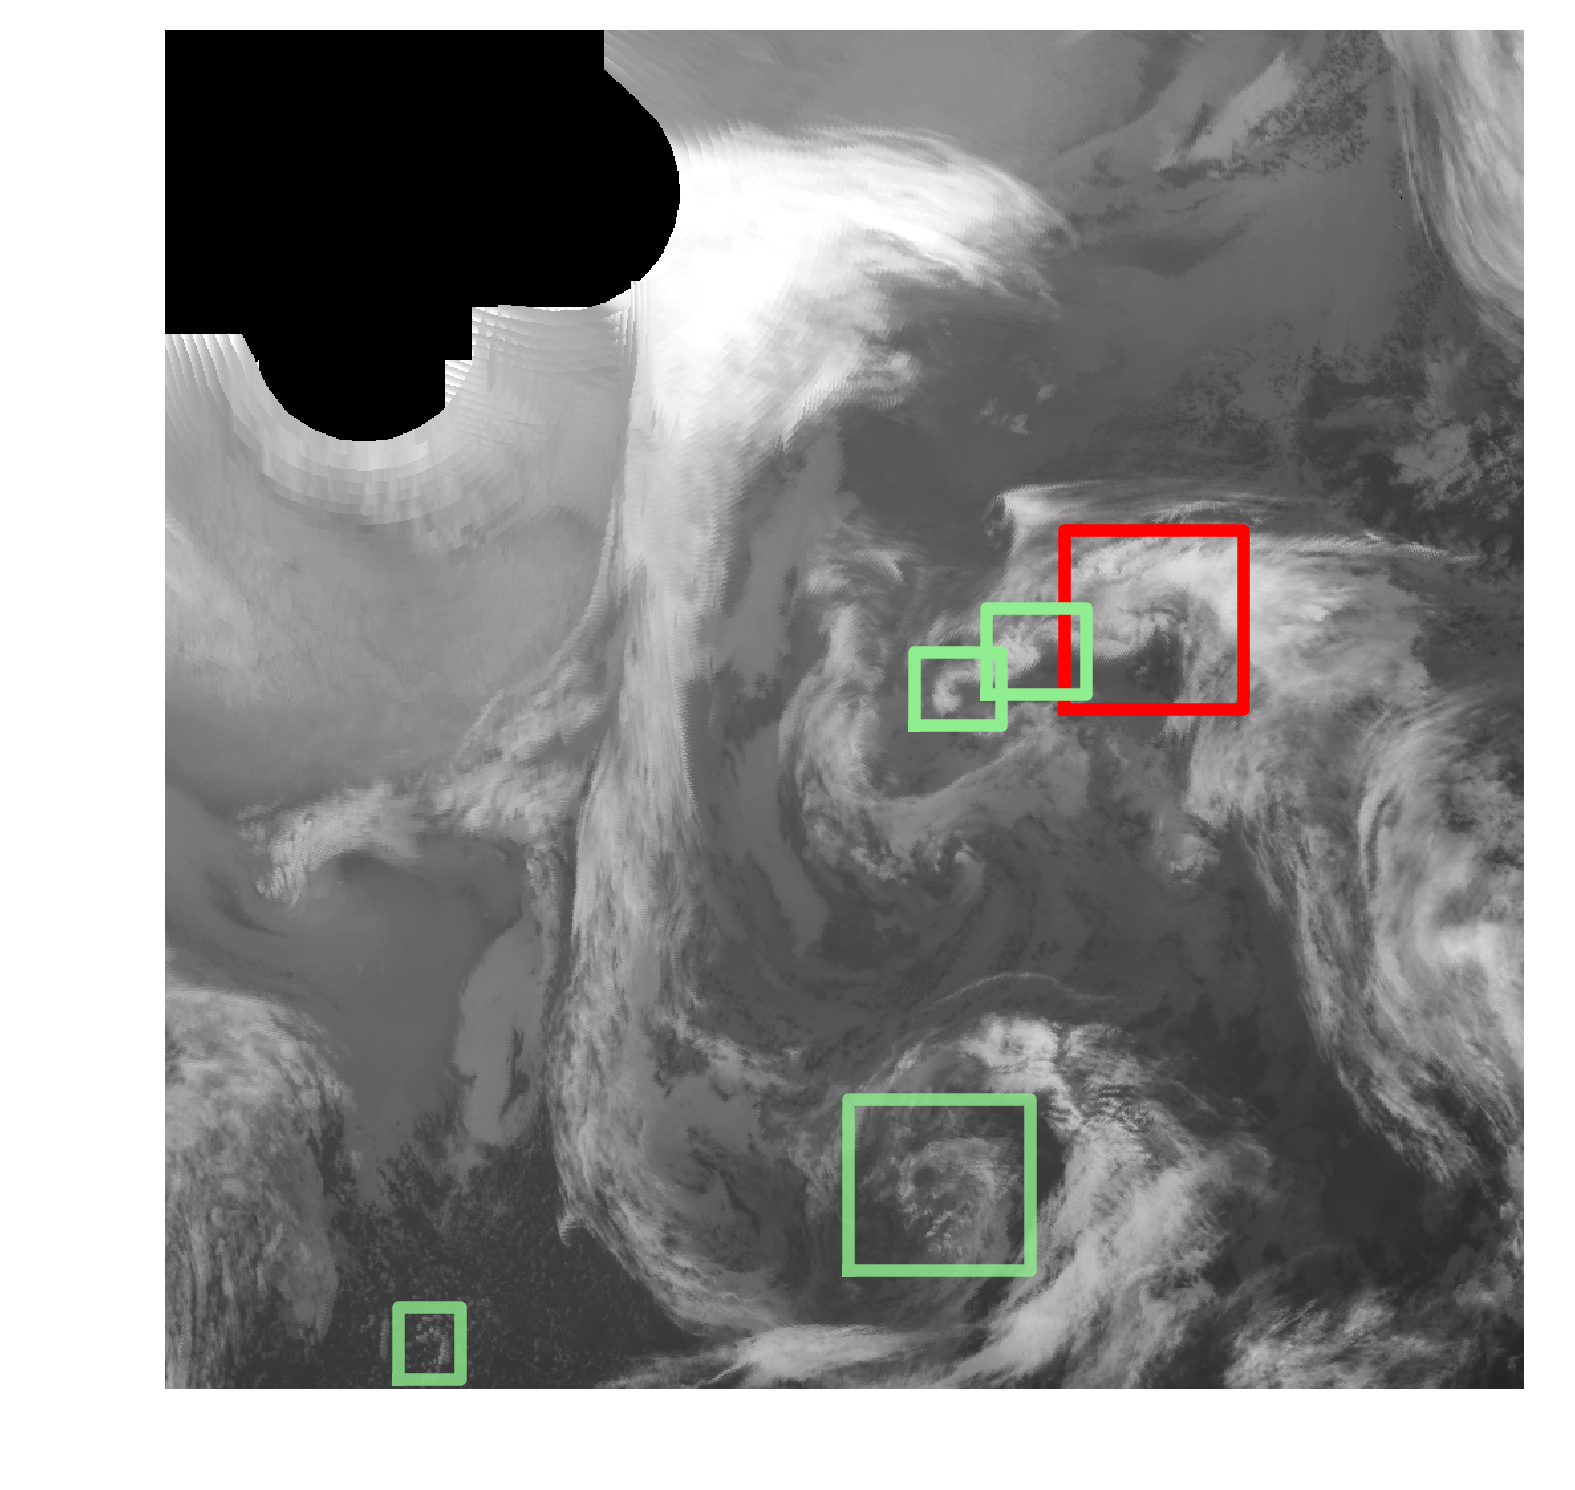

In [53]:
plt.imshow(image[:, :, 0], cmap='gray', vmin=0, vmax=255)
for i in range(annotations['bboxes'].shape[0]):
    label = annotations['labels'][i]
    box = annotations['bboxes'][i]
    x1, y1, x2, y2 = np.array(box).astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color='red', linewidth=3)
for bbox, proba in zip(bboxes_filtered, scores_filtered):
    x1, y1, x2, y2 = bbox.astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color='lightgreen', linewidth=3, alpha = proba/probas.max())
#     plt.text(x1, y1, '%.3f' % proba, fontsize = 10)
_ = plt.axis('off')

In [32]:
curr_uid = test_generator.image_names[4]
curr_label = test_generator.data_manager.labels[curr_uid]

In [33]:
curr_label

{'crop_bbox': array([ 889,   45, 1913, 1069]),
 'crop_idx': 36,
 'data_fname_base': '77f688a9db274dd5b790dc02bdb0d6f1',
 'dt': datetime.datetime(2004, 9, 28, 12, 0),
 'labels_bboxes': [{'bbox': array([677, 512, 812, 647]), 'class': 'MC'}],
 'transformed_data_idx': 0,
 'uid': '00120c145909484b912dbac8b8036003'}

In [34]:
data_fname_base = curr_label['data_fname_base']
data_fname_base

'77f688a9db274dd5b790dc02bdb0d6f1'

In [35]:
def label_uids_by_timedelta_hour(curr_label, hours = 3):
    keys = [key for key in test_generator.data_manager.labels if (test_generator.data_manager.labels[key]['dt'] - curr_label['dt']).total_seconds() == 3600*hours]
    return keys

In [36]:
uid_plus3h = label_uids_by_timedelta_hour(curr_label, hours = 3)[0]
uid_plus6h = label_uids_by_timedelta_hour(curr_label, hours = 6)[0]

In [37]:
test_generator.data_manager.labels[uid_plus3h]['dt']

datetime.datetime(2004, 9, 28, 15, 0)

In [38]:
test_generator.data_manager.labels[uid_plus6h]['dt']

datetime.datetime(2004, 9, 28, 18, 0)

In [39]:
uid_minus3h = label_uids_by_timedelta_hour(curr_label, hours = -3)[0]
uid_minus6h = label_uids_by_timedelta_hour(curr_label, hours = -6)[0]

In [40]:
test_generator.data_manager.labels[uid_minus3h]['dt']

datetime.datetime(2004, 9, 28, 9, 0)

In [41]:
test_generator.data_manager.labels[uid_minus6h]['dt']

datetime.datetime(2004, 9, 28, 6, 0)

In [42]:
# remember - it is just one of 64 crops per that datetime snapshot
label_minus6h = test_generator.data_manager.labels[uid_minus6h]
label_minus3h = test_generator.data_manager.labels[uid_minus3h]
label_plus3h = test_generator.data_manager.labels[uid_plus3h]
label_plus6h = test_generator.data_manager.labels[uid_plus6h]

# now - get data_fname_base
data_fname_base_plus3h = label_plus3h['data_fname_base']
data_fname_base_plus6h = label_plus6h['data_fname_base']
data_fname_base_minus3h = label_minus3h['data_fname_base']
data_fname_base_minus6h = label_minus6h['data_fname_base']

In [43]:
label_plus6h['transformed_data_idx']

0

In [44]:
data_filename_minus6h = os.path.join(test_generator.data_manager.base_directory,
                                     'data_%s.npy' % data_fname_base_minus6h)
data_filename_minus3h = os.path.join(test_generator.data_manager.base_directory,
                                     'data_%s.npy' % data_fname_base_minus3h)
data_filename_plus3h = os.path.join(test_generator.data_manager.base_directory,
                                     'data_%s.npy' % data_fname_base_plus3h)
data_filename_plus6h = os.path.join(test_generator.data_manager.base_directory,
                                     'data_%s.npy' % data_fname_base_plus6h)

In [45]:
[data_fname_base_minus6h, data_fname_base_minus3h, data_fname_base_plus3h, data_fname_base_plus6h]

['b1cc8ead9a2043dd911ec22d4eb04e76',
 '419b100b30284f319fa922cb5f0c8c36',
 '381df174ef39430fa9858470d7b0d25f',
 'e104a7f46e2f4af8ab0e4a3f655512c1']

In [47]:
data_minus6h = np.squeeze(np.load(data_filename_minus6h)[:])
data_minus6h[:, :, 0] = 255 - data_minus6h[:, :, 0]
data_minus6h[:, :, 1] = 255 - data_minus6h[:, :, 1]
# data_minus6h = data_minus6h[]
data_minus3h = np.squeeze(np.load(data_filename_minus3h)[:])
data_minus3h[:, :, 0] = 255 - data_minus3h[:, :, 0]
data_minus3h[:, :, 1] = 255 - data_minus3h[:, :, 1]
data_plus3h = np.squeeze(np.load(data_filename_plus3h)[:])
data_plus3h[:, :, 0] = 255 - data_plus3h[:, :, 0]
data_plus3h[:, :, 1] = 255 - data_plus3h[:, :, 1]
data_plus6h = np.squeeze(np.load(data_filename_plus6h)[:])
data_plus6h[:, :, 0] = 255 - data_plus6h[:, :, 0]
data_plus6h[:, :, 1] = 255 - data_plus6h[:, :, 1]

In [48]:
x1, y1, x2, y2 = curr_label['crop_bbox']  # (4,) in x1y1x2y2 format
data_minus6h_example_crop = data_minus6h[y1:y2, x1:x2]
data_minus3h_example_crop = data_minus3h[y1:y2, x1:x2]
data_plus3h_example_crop = data_plus3h[y1:y2, x1:x2]
data_plus6h_example_crop = data_plus6h[y1:y2, x1:x2]

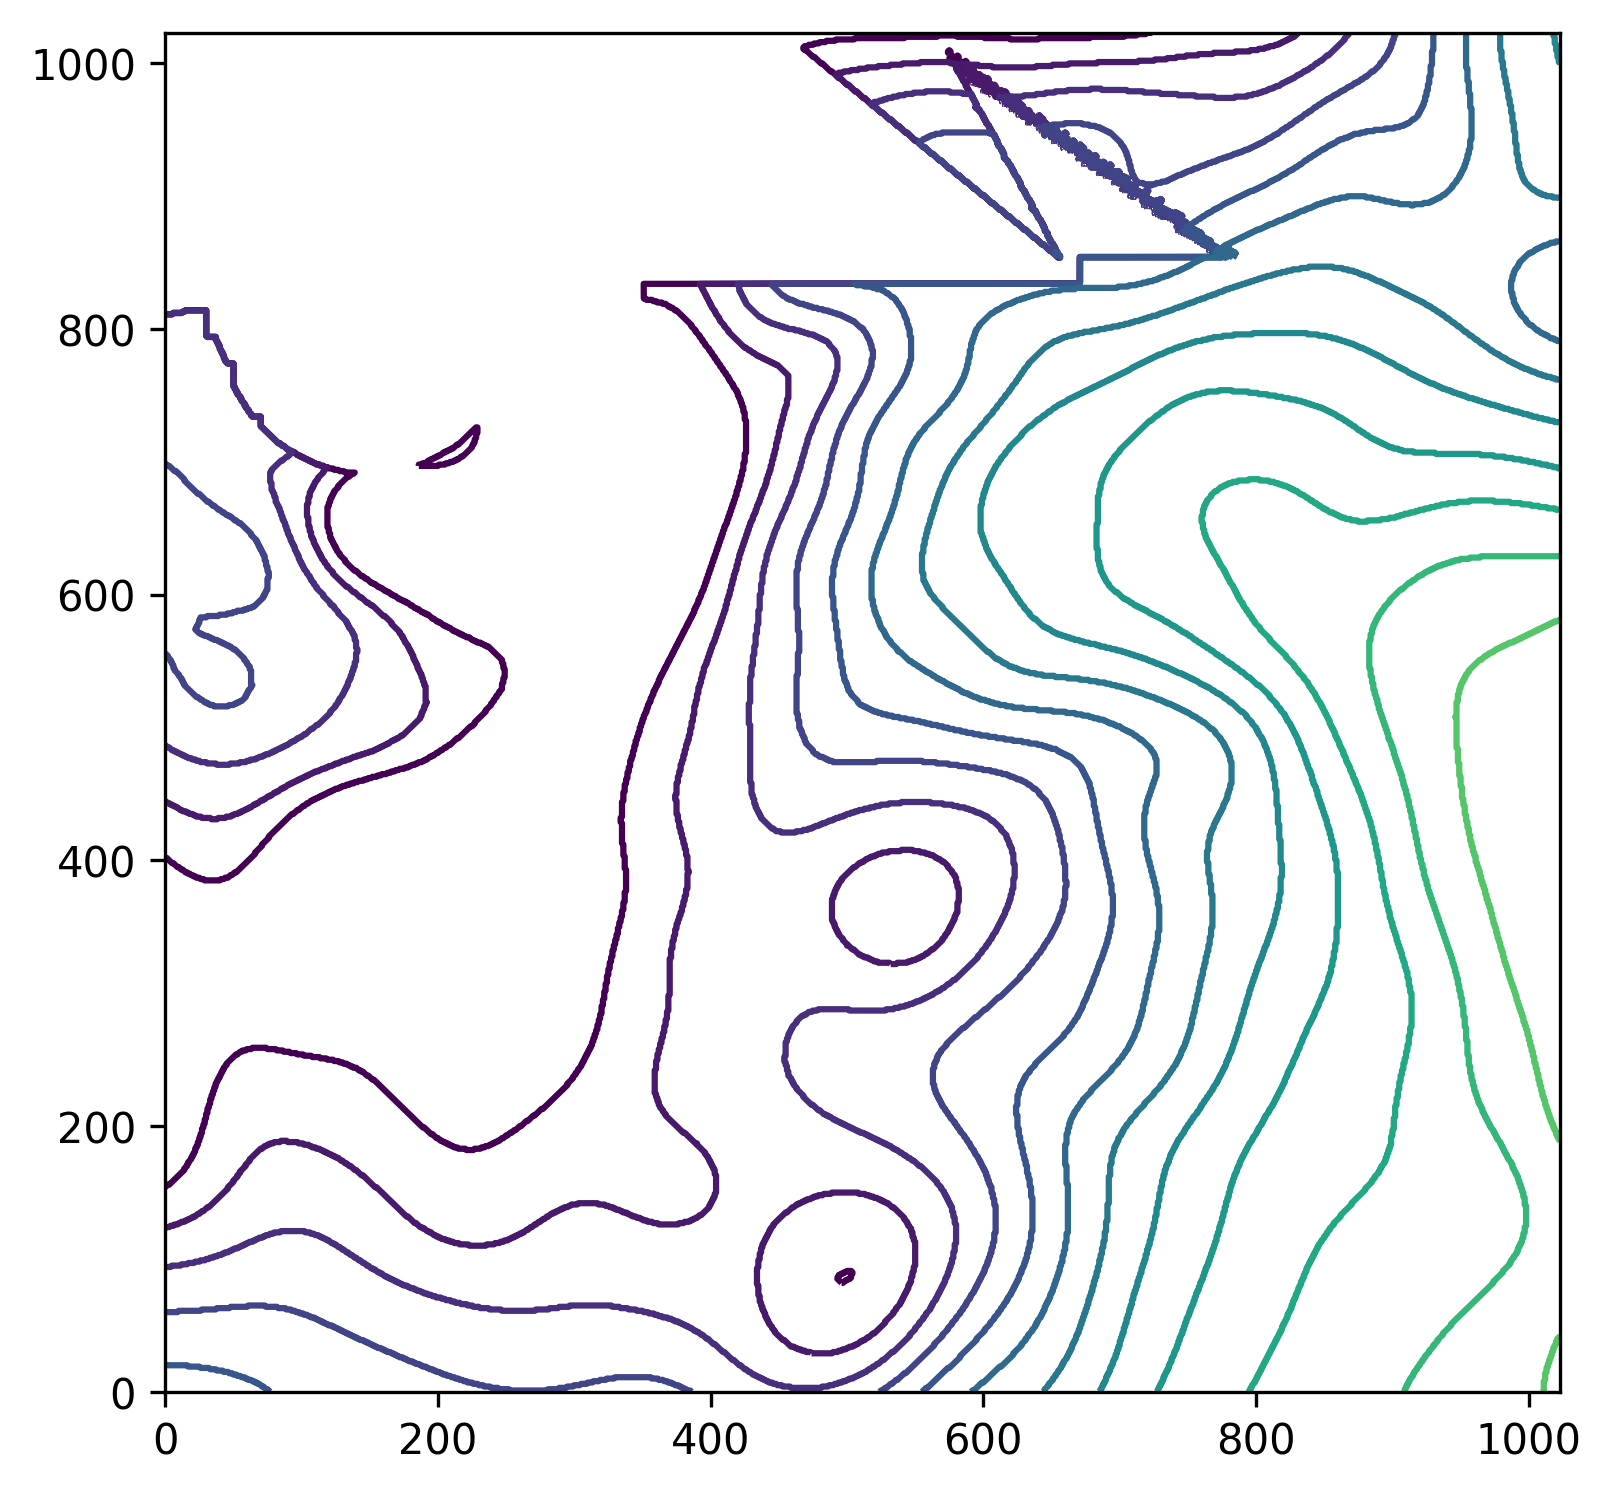

In [98]:
plt.contour(data_minus6h_example_crop[:, :, 2], levels=np.arange(100, 251, 10))

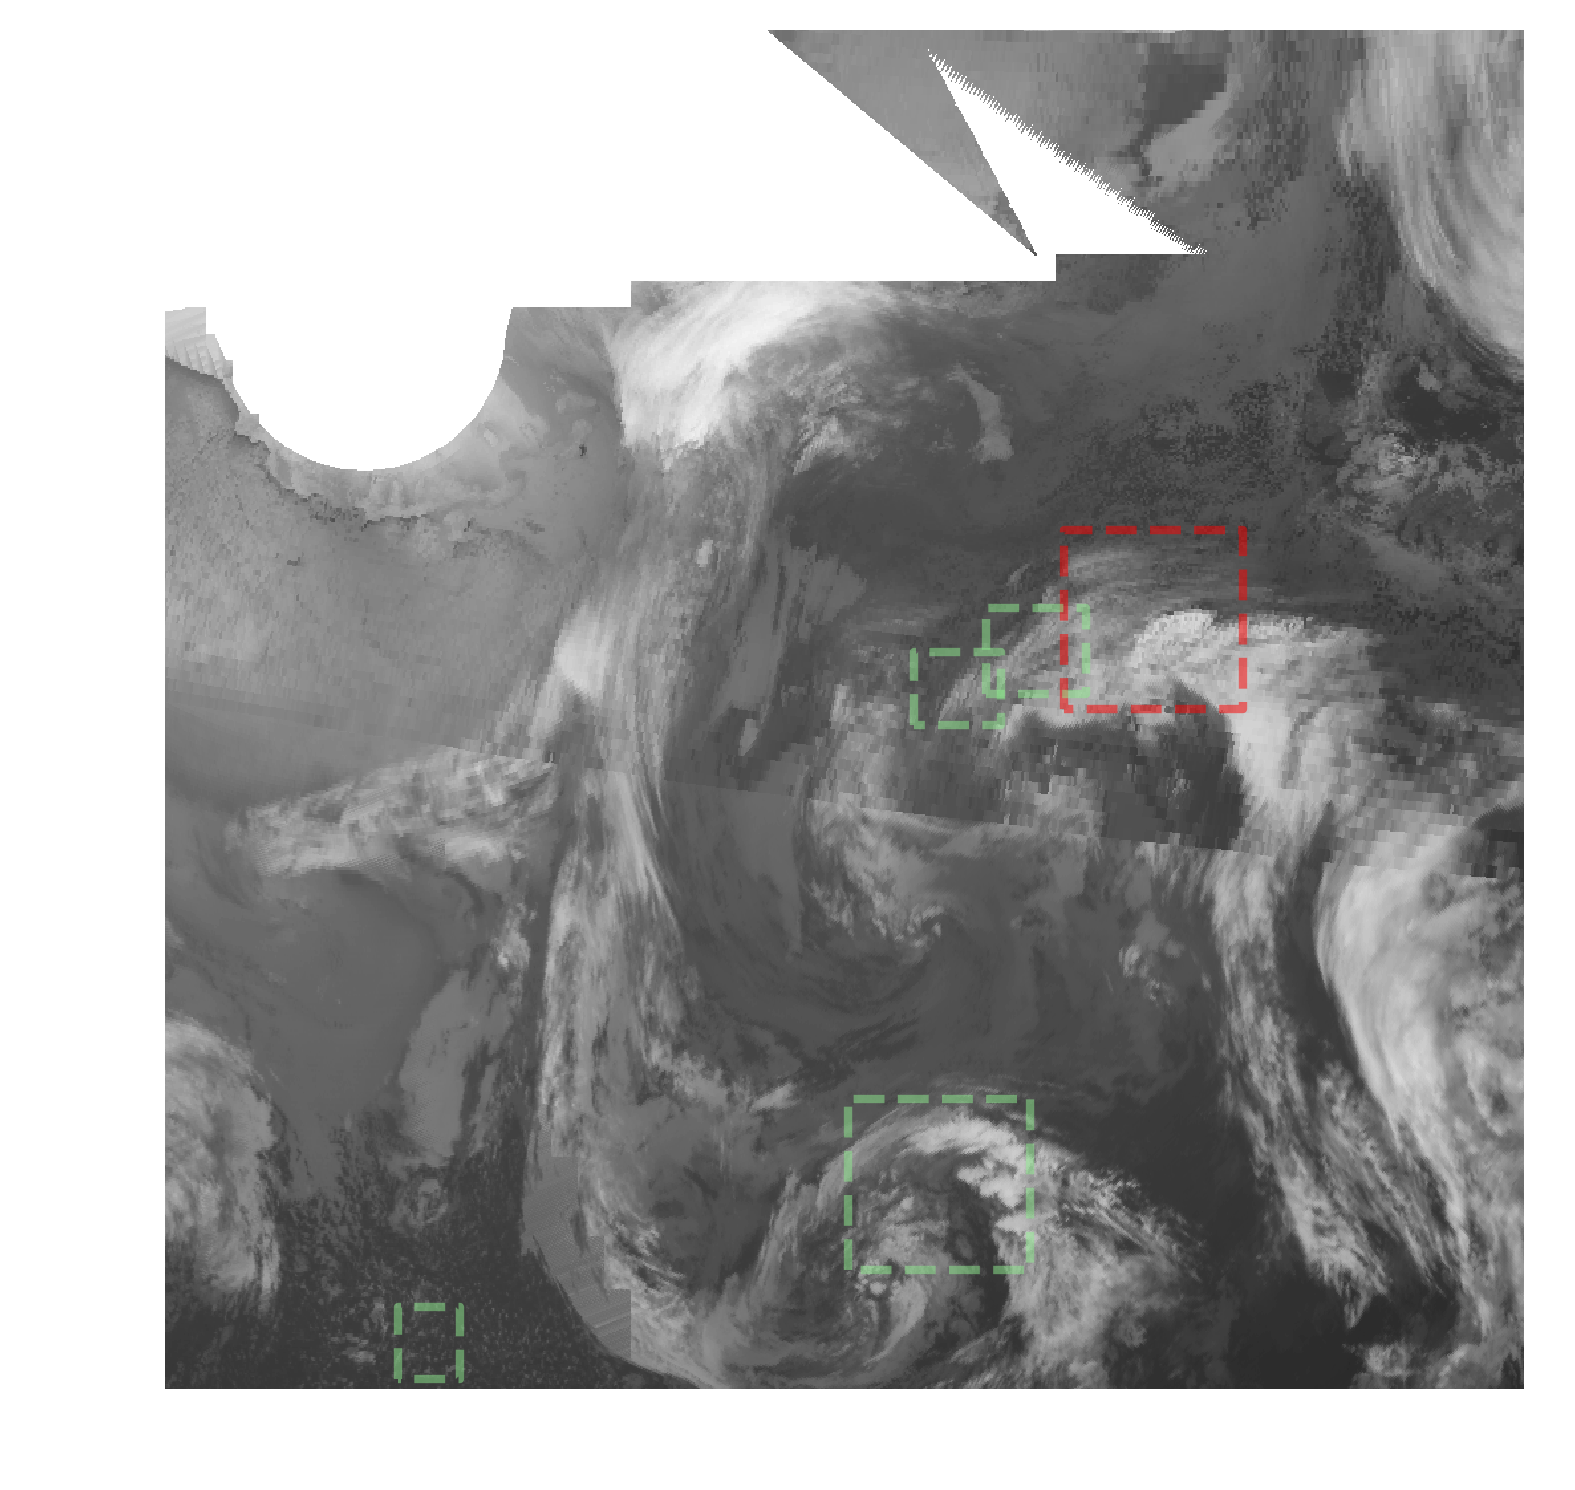

In [49]:
plt.imshow(data_minus6h_example_crop[:, :, 0], cmap='gray', vmin=0, vmax=255)

for i in range(annotations['bboxes'].shape[0]):
    label = annotations['labels'][i]
    box = annotations['bboxes'][i]
    x1, y1, x2, y2 = np.array(box).astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], '--', color='red', linewidth=2, alpha = 0.5)
for bbox, proba in zip(bboxes_filtered, scores_filtered):
    x1, y1, x2, y2 = bbox.astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], '--', color='lightgreen', linewidth=2, alpha = 0.5)
#     plt.text(x1, y1, '%.3f' % proba, fontsize = 10)
_ = plt.axis('off')

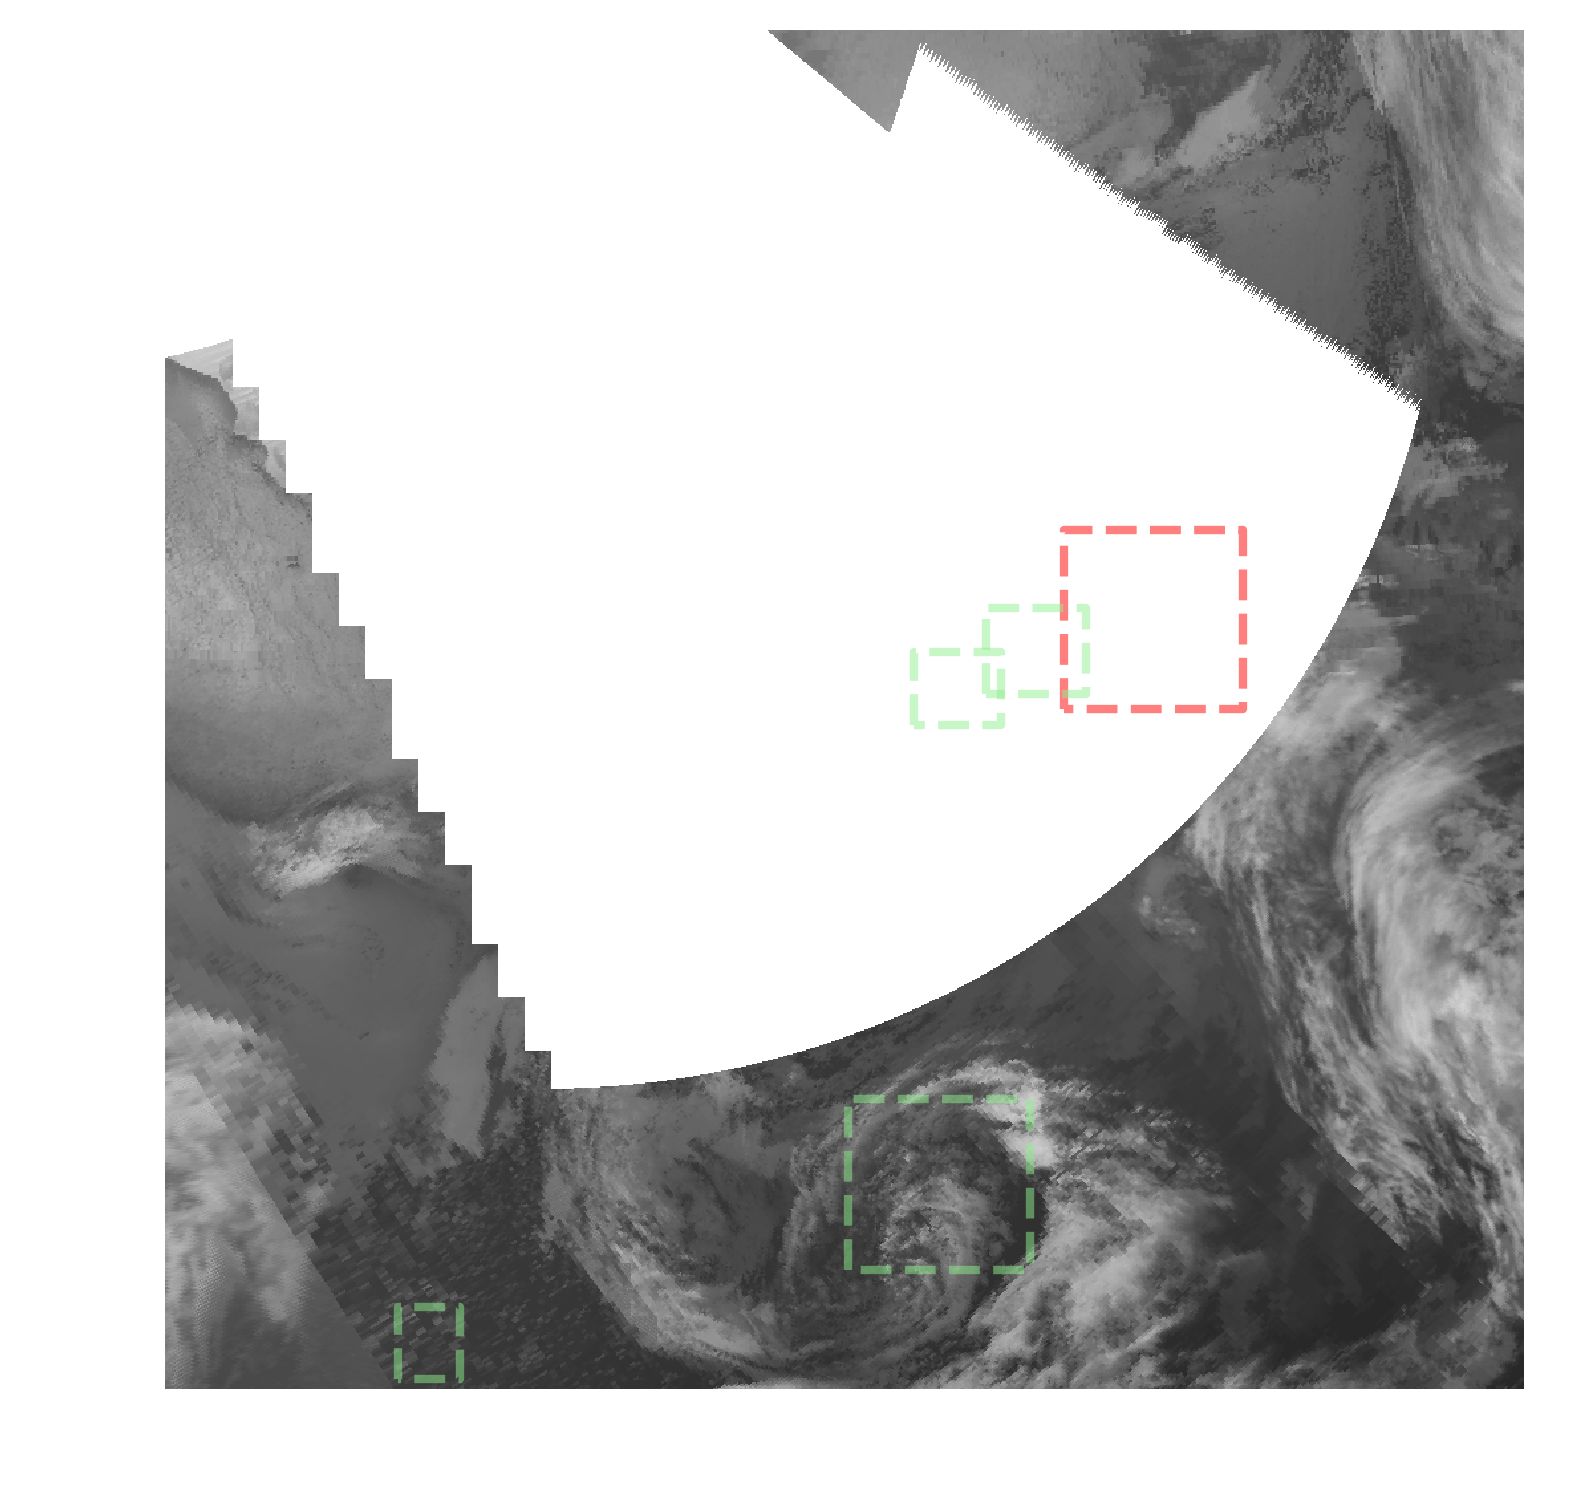

In [50]:
plt.imshow(data_minus3h_example_crop[:, :, 0], cmap='gray', vmin=0, vmax=255)
for i in range(annotations['bboxes'].shape[0]):
    label = annotations['labels'][i]
    box = annotations['bboxes'][i]
    x1, y1, x2, y2 = np.array(box).astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], '--', color='red', linewidth=2, alpha = 0.5)
for bbox, proba in zip(bboxes_filtered, scores_filtered):
    x1, y1, x2, y2 = bbox.astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], '--', color='lightgreen', linewidth=2, alpha = 0.5)
#     plt.text(x1, y1, '%.3f' % proba, fontsize = 10)
_ = plt.axis('off')

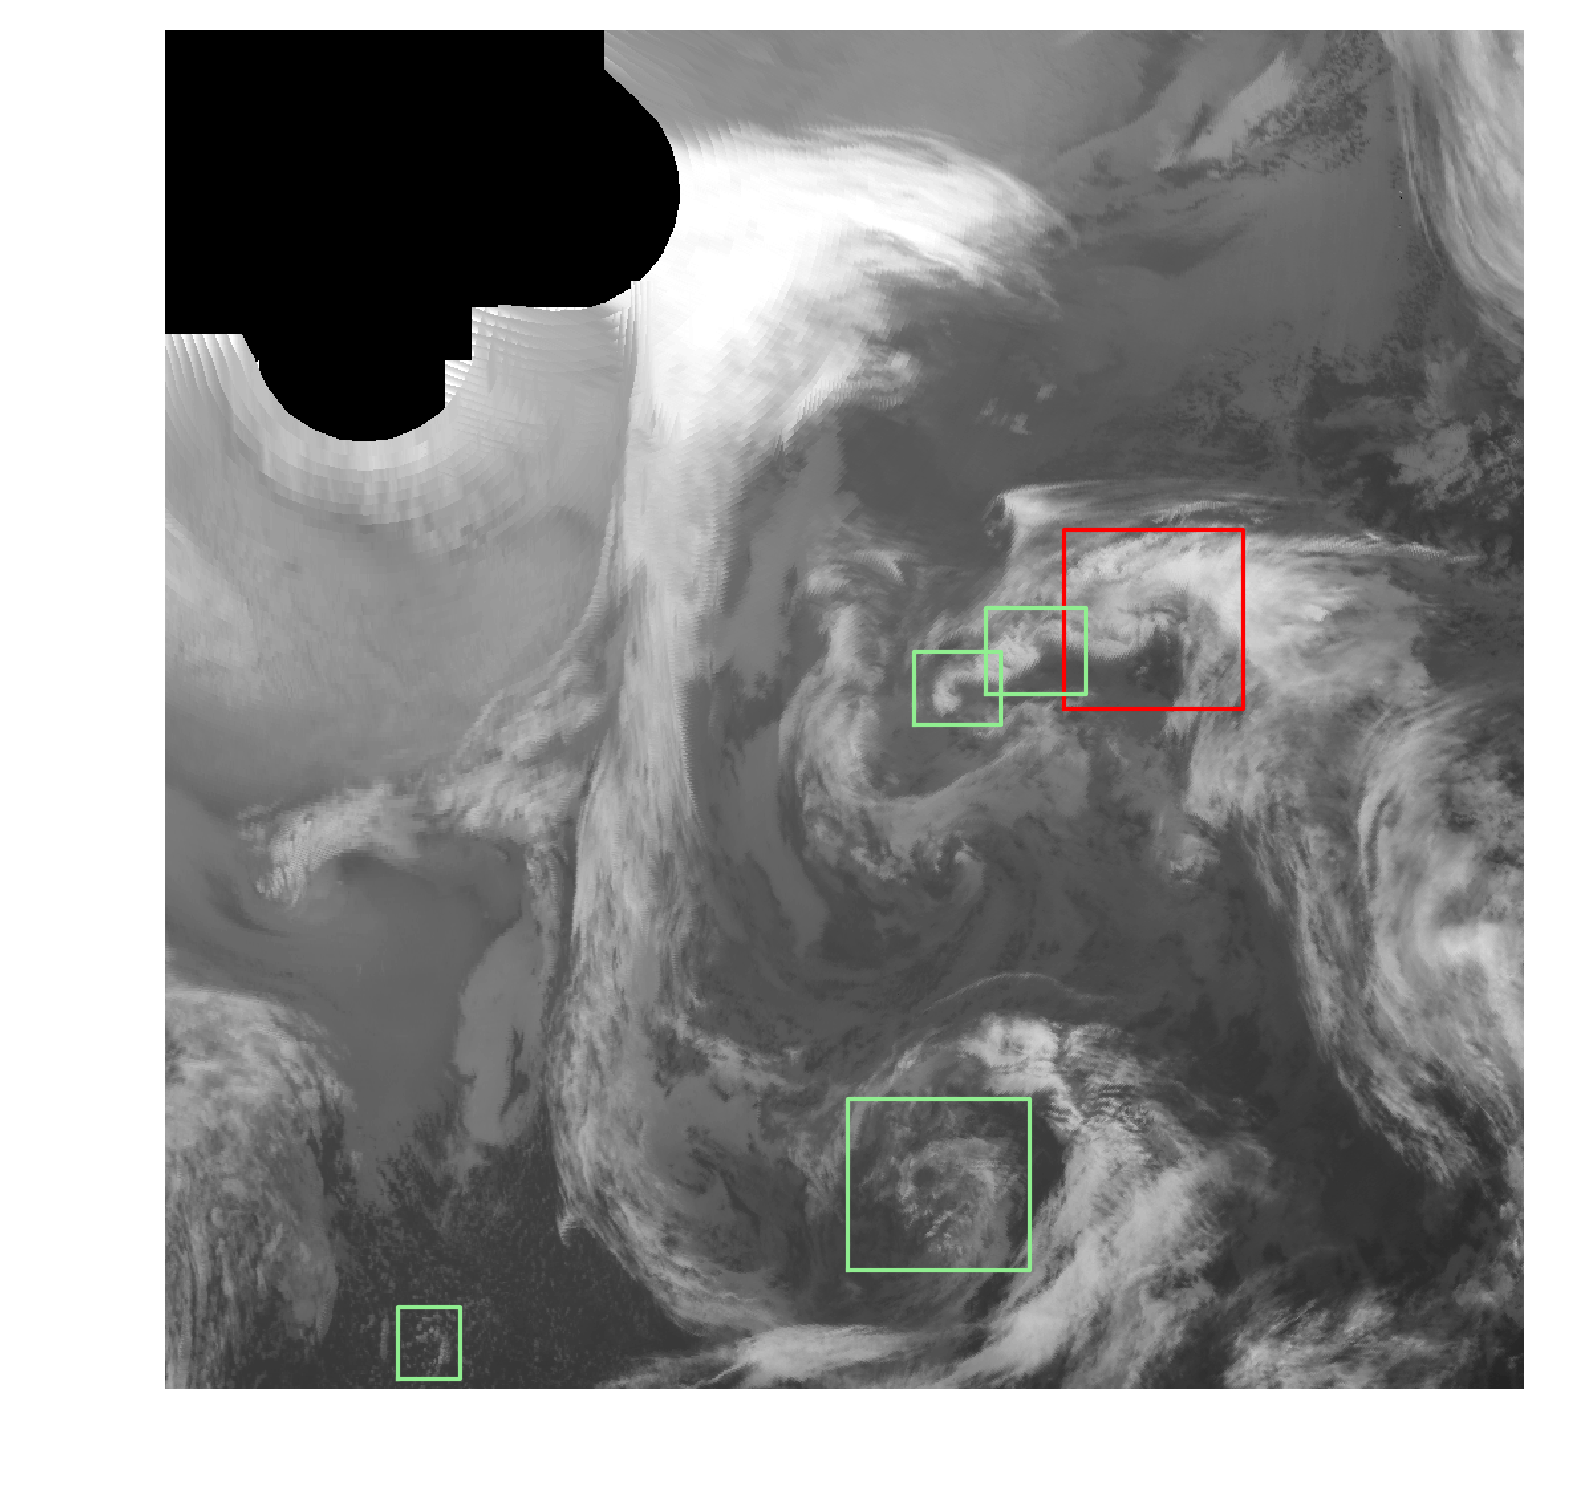

In [93]:
plt.imshow(image[:, :, 0], cmap='gray', vmin=0, vmax=255)
for i in range(annotations['bboxes'].shape[0]):
    label = annotations['labels'][i]
    box = annotations['bboxes'][i]
    x1, y1, x2, y2 = np.array(box).astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color='red', linewidth=1)
for bbox, proba in zip(bboxes_filtered, scores_filtered):
    x1, y1, x2, y2 = bbox.astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color='lightgreen', linewidth=1)
#     plt.text(x1, y1, '%.3f' % proba, fontsize = 10)
_ = plt.axis('off')

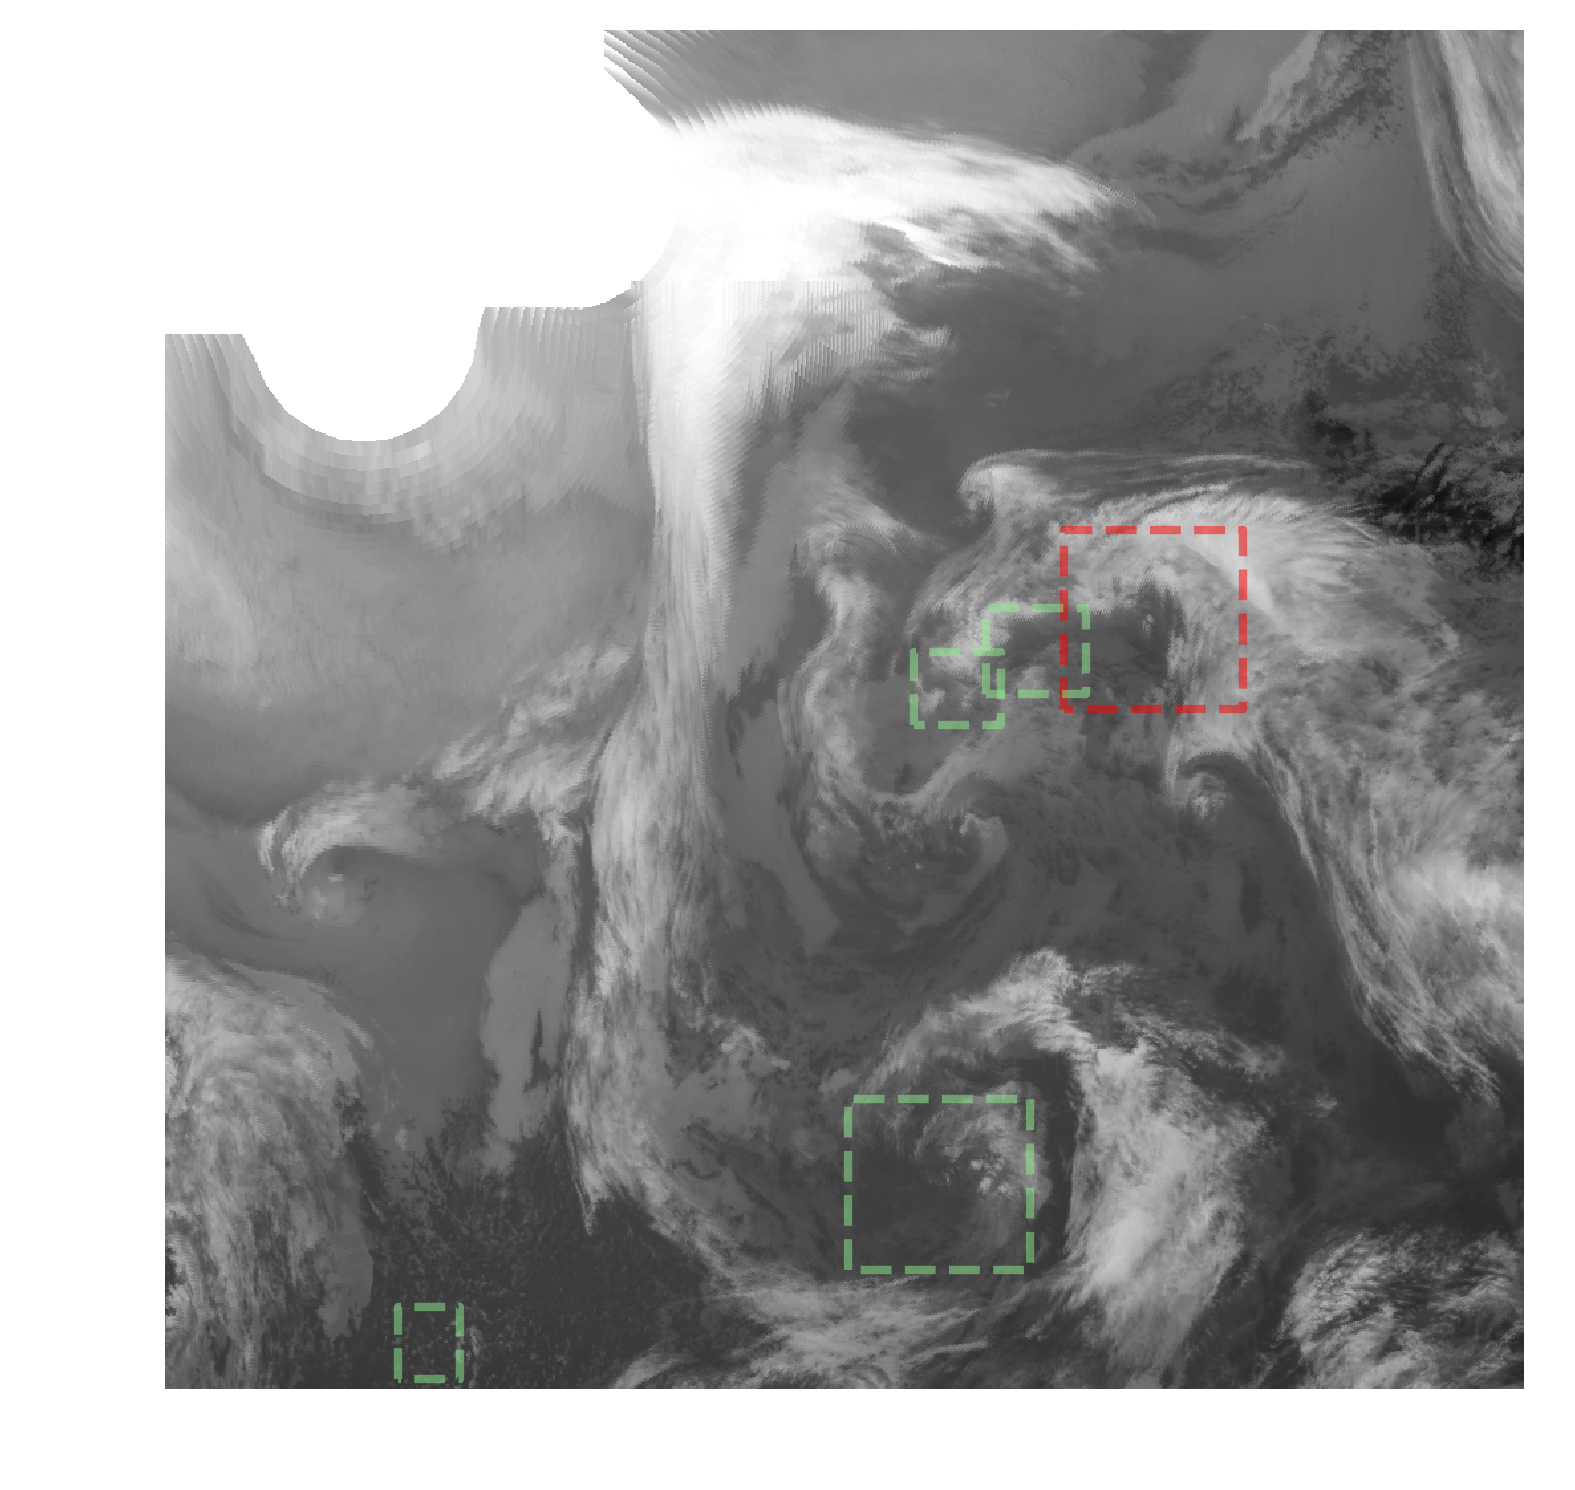

In [51]:
plt.imshow(data_plus3h_example_crop[:, :, 0], cmap='gray', vmin=0, vmax=255)
for i in range(annotations['bboxes'].shape[0]):
    label = annotations['labels'][i]
    box = annotations['bboxes'][i]
    x1, y1, x2, y2 = np.array(box).astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], '--', color='red', linewidth=2, alpha = 0.5)
for bbox, proba in zip(bboxes_filtered, scores_filtered):
    x1, y1, x2, y2 = bbox.astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], '--', color='lightgreen', linewidth=2, alpha = 0.5)
#     plt.text(x1, y1, '%.3f' % proba, fontsize = 10)
_ = plt.axis('off')

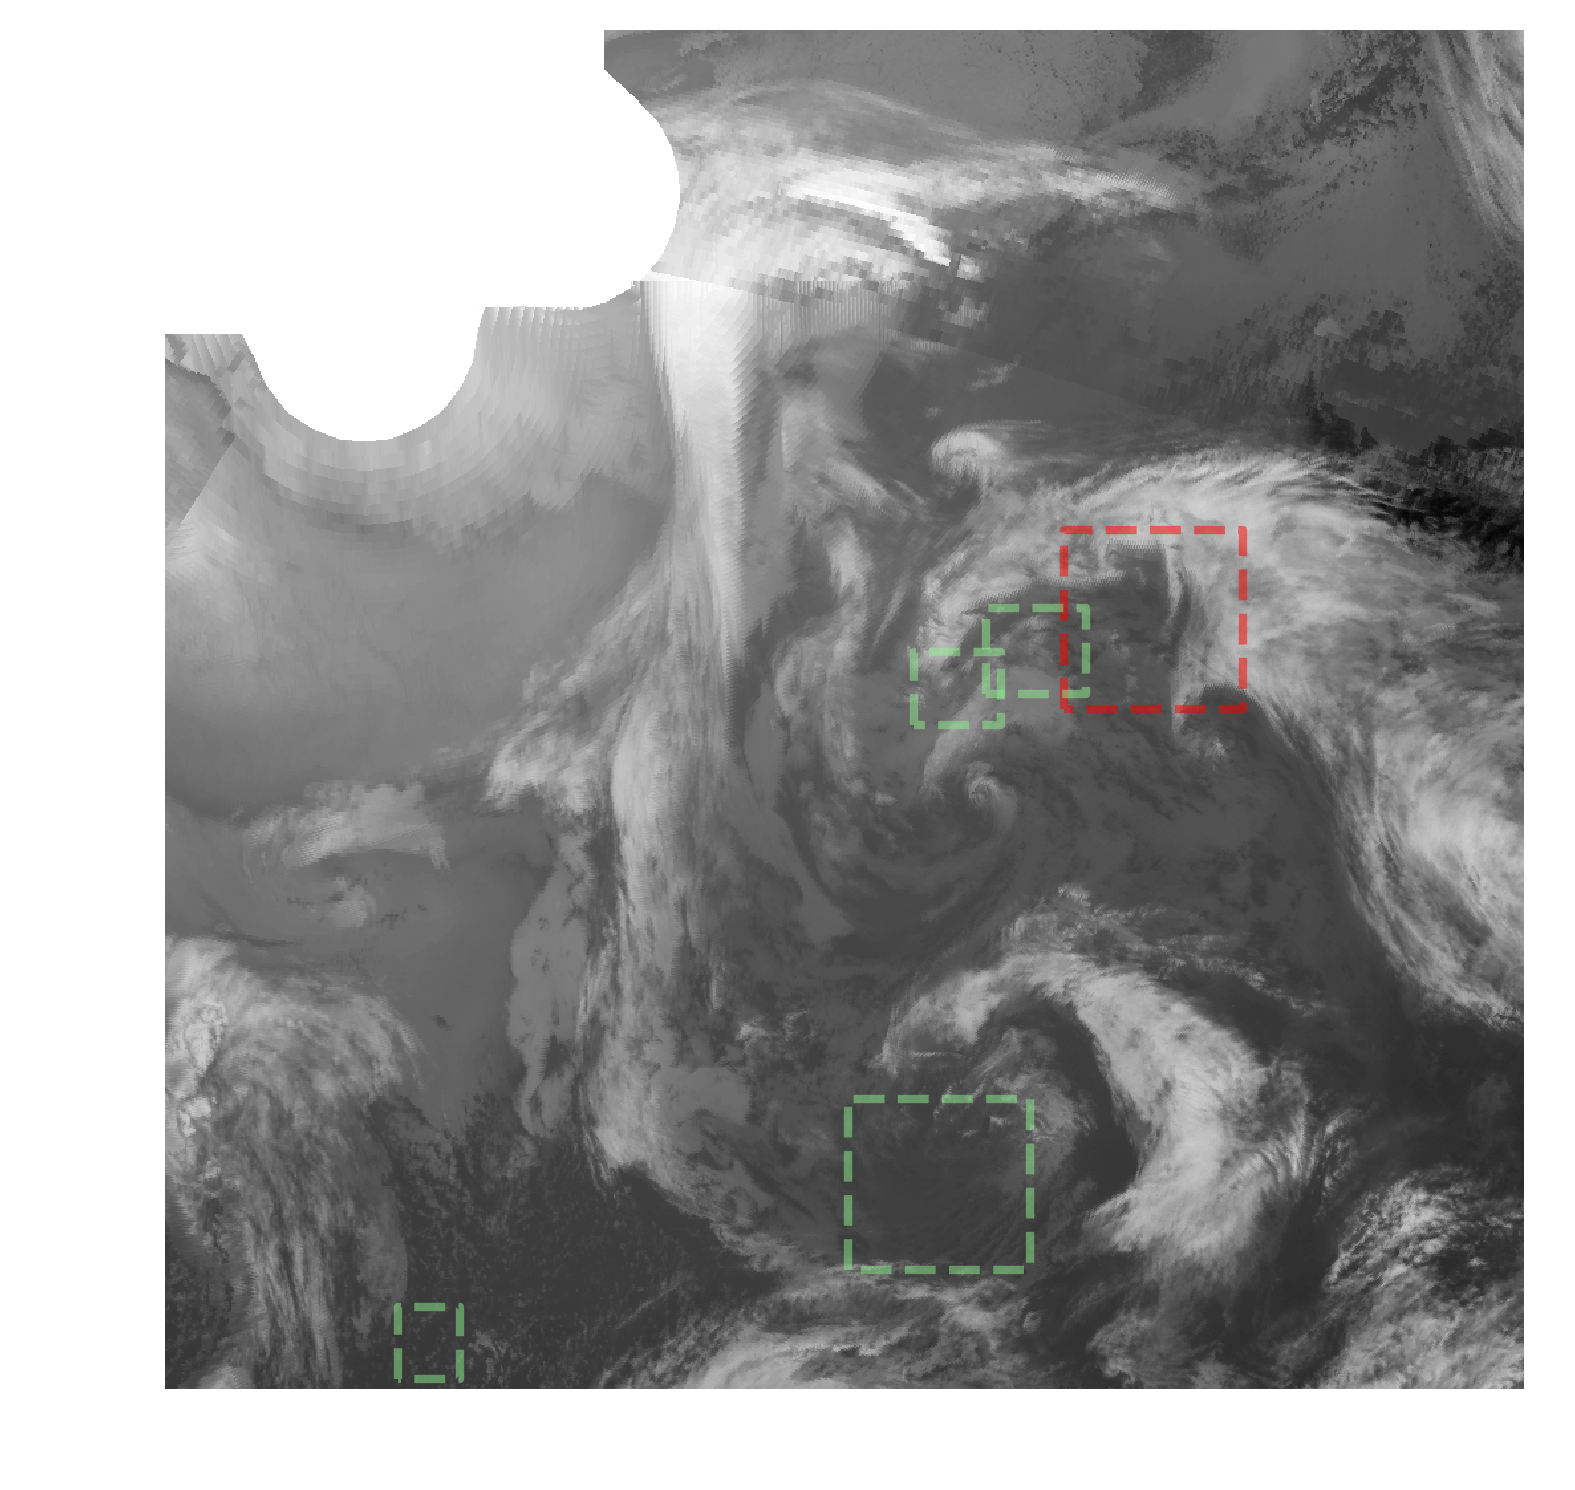

In [52]:
plt.imshow(data_plus6h_example_crop[:, :, 0], cmap='gray', vmin=0, vmax=255)
for i in range(annotations['bboxes'].shape[0]):
    label = annotations['labels'][i]
    box = annotations['bboxes'][i]
    x1, y1, x2, y2 = np.array(box).astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], '--', color='red', linewidth=2, alpha = 0.5)
for bbox, proba in zip(bboxes_filtered, scores_filtered):
    x1, y1, x2, y2 = bbox.astype(int)
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], '--', color='lightgreen', linewidth=2, alpha = 0.5)
#     plt.text(x1, y1, '%.3f' % proba, fontsize = 10)
_ = plt.axis('off')